<a href="https://colab.research.google.com/github/pmaher86/emoji-GAN/blob/master/Generating_new_emoji_with_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a brief exploration of how we can use Generative Adversarial Networks to synthesize new emojis. To be clear, we'll be aiming for completely new shapes, not new facial emotions. I think this is an interesting dataset to test GANs on because 1) emoji are small and comprise a decent-size dataset, and 2) more than a few emoji already look indecipherable, so it shouldn't be too hard to reach a level of performance where the results are plausibly new emoji 😆

# Import Packages


In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from urllib.request import urlretrieve
%matplotlib inline
import sys, os, glob
from scipy import misc
import IPython

import numpy as np


Make sure that we're using a GPU backend

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5510084062444896517
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11794485685500468251
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6073333387413344288
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6329781481436637024
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# Download Data
Here's where we pull the emoji data and set up our training set. We'll use all the 64-bit emojis, and use the different variants (iOS, Android, etc.) to increase the size of our training data

In [0]:
urlretrieve('https://github.com/iamcal/emoji-data/archive/master.zip','emoji.zip')
!unzip -q emoji.zip

In [0]:
files = glob.glob('emoji-data-master/*-64/*')
all_imgs = [misc.imread(file) for file in files]
X_train = np.stack([im for im in all_imgs if im.shape==(64,64,4)])
X_train = X_train / 127.5 - 1.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


# Define Our First Model
We'll start with a simple GAN fully connected layers. Throughout this I'm borrowing heavily from the keras implementations of different Generative Adversarial Networks [here](https://github.com/eriklindernoren/Keras-GAN).  

In [0]:
class GAN:
  def __init__(self):
    self.img_rows = 64
    self.img_cols = 64
    self.channels = 4
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100

    optimizer = Adam(0.0002, 0.5)
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',
      optimizer=optimizer, metrics=['accuracy'])

    self.generator = self.build_generator()
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    validity = self.discriminator(img)
    self.combined = Model(z, validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  def build_generator(self):
    model = Sequential()
    layer_sizes = [256, 512, 1024]
    
    for i, layer_size in enumerate(layer_sizes):
      kwargs = {'input_dim':self.latent_dim} if i==0 else {}
      model.add(Dense(layer_size, **kwargs))
      model.add(Activation('relu'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(Dropout(0.2))
    
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))    
    return model

  def build_discriminator(self):
    model = Sequential()
    layer_sizes = [512, 256]
    
    model.add(Flatten(input_shape=self.img_shape))
    for i, layer_size in enumerate(layer_sizes):
      model.add(Dense(layer_size))
      model.add(Activation('relu'))
      model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

  def train(self, X_train, epochs, batch_size=32, sample_interval=50, log_prefix='images'):
    os.makedirs(f'{log_prefix}_images', exist_ok=True)
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
  
    for epoch in range(epochs):
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      gen_imgs = self.generator.predict(noise)

      d_loss_real = self.discriminator.train_on_batch(imgs, valid)
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      g_loss = self.combined.train_on_batch(noise, valid)

      if (epoch + 1) % sample_interval == 0:
          print(f'{epoch+1} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]:.2f}] [G loss: {g_loss}]')
          self.sample_images().savefig(f'{log_prefix}_images/{epoch+1:05d}.png')
  
  def sample_images(self, n_rows=5, n_cols=5): 
    noise = np.random.normal(0, 1, (n_rows * n_cols, self.latent_dim))
    images = self.generator.predict(noise)/2.0 + 0.5
    fig, axs = plt.subplots(n_rows, n_cols)
    for i,ax in enumerate(fig.axes):
      ax.imshow(images[i,:,:,:])
      ax.axis('off')
    plt.close()
    return fig


In [0]:
g = GAN()
g.train(X_train, epochs=5000, batch_size=32, sample_interval=500, log_prefix='gan')

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.36522507667541504, acc.: 84.38] [G loss: 1.5553898811340332]
1000 [D loss: 0.542142927646637, acc.: 73.44] [G loss: 1.2624669075012207]
1500 [D loss: 0.5336582064628601, acc.: 73.44] [G loss: 1.3707640171051025]
2000 [D loss: 0.5079991817474365, acc.: 70.31] [G loss: 1.4802234172821045]
2500 [D loss: 0.4421200156211853, acc.: 82.81] [G loss: 1.5261566638946533]
3000 [D loss: 0.4874199330806732, acc.: 76.56] [G loss: 1.4186670780181885]
3500 [D loss: 0.5153997540473938, acc.: 70.31] [G loss: 1.6479988098144531]
4000 [D loss: 0.4238234758377075, acc.: 76.56] [G loss: 1.4301254749298096]
4500 [D loss: 0.39699673652648926, acc.: 82.81] [G loss: 1.5284423828125]
5000 [D loss: 0.3078520596027374, acc.: 84.38] [G loss: 1.5800230503082275]


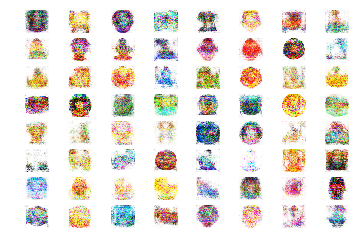

In [0]:
g.sample_images(8,8)

What we see is that this model learns a lot of the common emoji types, like faces or country flags. However, the output has lots of pixel-level noise. This makes sense: because of their dense connection, neither the discriminator nor the generator have any sense of locality--that is, they treat neighboring pixels the same as every other pixel in the image. Let's first try using a convolutional discriminator to see if we can force the generator to create smoother images.

# Convolutional Discriminator

In [0]:
class Conv_GAN(GAN):
  def build_discriminator(self):
    model = Sequential()
    layer_sizes = [32, 64, 128, 256]
    
    for i, layer_size in enumerate(layer_sizes):
      kwargs = {'input_shape':self.img_shape} if i==0 else {}
      model.add(Conv2D(layer_size, (4, 4), padding='same', **kwargs))
      model.add(Activation('relu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


In [0]:
cg = Conv_GAN()
cg.train(X_train, epochs=5000, batch_size=32, sample_interval=500, log_prefix='conv_gan')

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.0460645817220211, acc.: 100.00] [G loss: 4.067083358764648]
1000 [D loss: 0.10159024596214294, acc.: 98.44] [G loss: 2.6124706268310547]
1500 [D loss: 0.04670523479580879, acc.: 98.44] [G loss: 4.124607086181641]
2000 [D loss: 0.20005401968955994, acc.: 92.19] [G loss: 4.083786964416504]
2500 [D loss: 0.2155732661485672, acc.: 92.19] [G loss: 3.9385452270507812]
3000 [D loss: 0.4989141523838043, acc.: 82.81] [G loss: 3.4977431297302246]
3500 [D loss: 0.06801586598157883, acc.: 96.88] [G loss: 4.017253875732422]
4000 [D loss: 0.06245255470275879, acc.: 98.44] [G loss: 4.282374382019043]
4500 [D loss: 0.03348373621702194, acc.: 100.00] [G loss: 4.53054141998291]
5000 [D loss: 0.21073982119560242, acc.: 96.88] [G loss: 5.102161884307861]


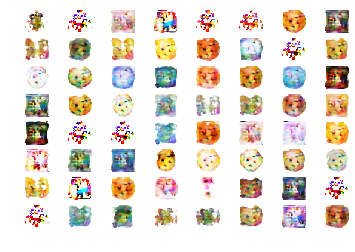

In [0]:
cg.sample_images(8,8)

This looks better, in the sense that we're seeing clear substructure that looks emoji-like, but we're observing mode collapse. That is, the generator is learning only a few of the modes that can fool the discriminator, and transforming all noise into one of those few modes. There are ways of dealing with this, like [unrolled training](https://arxiv.org/abs/1611.02163), but maybe we can get around this by moving to a model architecture where the generator has less control over global structure.

# Convolutional Generator

In [0]:
class All_Conv_GAN(Conv_GAN):
  def build_generator(self):
    model = Sequential()
    layer_sizes = [64, 32]
    
    model.add(Dense(64 * 16 * 16, activation="relu", input_dim=self.latent_dim))
    model.add(Reshape((16, 16, 64)))
    
    for layer_size in layer_sizes:
      model.add(UpSampling2D())
      model.add(Conv2D(layer_size, kernel_size=3, padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))
    
    model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh")) 
    return model

In [0]:
acg = All_Conv_GAN()
acg.train(X_train, epochs=5000, batch_size=32, sample_interval=500, log_prefix='all_conv_gan')

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.5746434330940247, acc.: 73.44] [G loss: 0.9145649075508118]
1000 [D loss: 0.5388481616973877, acc.: 76.56] [G loss: 1.9578158855438232]
1500 [D loss: 0.16709429025650024, acc.: 96.88] [G loss: 2.733640670776367]
2000 [D loss: 0.3805900812149048, acc.: 84.38] [G loss: 2.3385331630706787]
2500 [D loss: 0.3312267065048218, acc.: 85.94] [G loss: 3.765772819519043]
3000 [D loss: 0.10083235800266266, acc.: 96.88] [G loss: 3.54337739944458]
3500 [D loss: 0.13993161916732788, acc.: 95.31] [G loss: 4.49816370010376]
4000 [D loss: 0.12050909548997879, acc.: 93.75] [G loss: 4.9427666664123535]
4500 [D loss: 0.04177536070346832, acc.: 100.00] [G loss: 5.006927490234375]
5000 [D loss: 0.0225802231580019, acc.: 100.00] [G loss: 4.309804916381836]


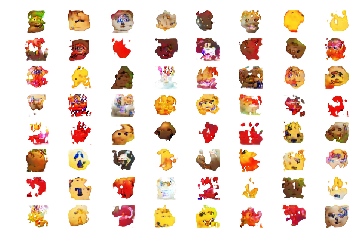

In [0]:
acg.sample_images(8,8)

This looks much, much better. We see a much bigger range of outputs, and some things like genuinely look like new (albeit unfamiliar) new emojis. This raises the question though--is the convolutional generator on its own enough? Let's try a network with a fully connected discriminator and a convolutional generator.

# Testing a Convolutional Generator With a Dense Discriminator

In [0]:
class Conv_Gen_GAN(GAN):
  def build_generator(self):
    model = Sequential()
    layer_sizes = [64, 32]
    
    model.add(Dense(64 * 16 * 16, activation="relu", input_dim=self.latent_dim))
    model.add(Reshape((16, 16, 64)))
    
    for layer_size in layer_sizes:
      model.add(UpSampling2D())
      model.add(Conv2D(layer_size, kernel_size=3, padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))
    
    model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh")) 
    return model

In [0]:
cgg = Conv_Gen_GAN()
cgg.train(X_train, epochs=5000, batch_size=32, sample_interval=500, log_prefix='conv_gen_gan')

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.4668149948120117, acc.: 89.06] [G loss: 0.6142704486846924]
1000 [D loss: 0.25581175088882446, acc.: 90.62] [G loss: 0.7577435970306396]
1500 [D loss: 0.4775685667991638, acc.: 90.62] [G loss: 1.796295404434204]
2000 [D loss: 0.33371007442474365, acc.: 89.06] [G loss: 1.6882227659225464]
2500 [D loss: 0.4095269739627838, acc.: 84.38] [G loss: 1.232999563217163]
3000 [D loss: 0.2796594202518463, acc.: 90.62] [G loss: 1.4100372791290283]
3500 [D loss: 0.3961280286312103, acc.: 85.94] [G loss: 1.3600248098373413]
4000 [D loss: 0.42027580738067627, acc.: 79.69] [G loss: 1.362518548965454]
4500 [D loss: 0.46089333295822144, acc.: 79.69] [G loss: 1.6159398555755615]
5000 [D loss: 0.26579633355140686, acc.: 92.19] [G loss: 1.6531680822372437]


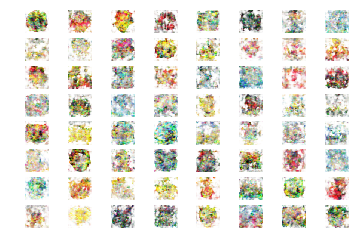

In [0]:
cgg.sample_images(8,8)

This doesn't look very good! Even though the noise is no longer pixel-level like our original attempt, there's still very little cohesion in the final images. Together, these results give us some intuition about the interplay between the discriminator and the generator. Because the generator can only learn what the discriminator knows, we want a discriminator that's powerful, but encodes the information in a way that's useful (i.e. emphasizing local structure through convolutional layers). If the generator is too powerful and we aren't careful in how we train, the generator might learn to exploit only a few solutions. Again, convolutional layers provide a good balance here.

# Styles From Different Emoji Sets
Finally, let's look at how our GAN performs on different training sets. We'll restrict our input data to the emoji sets from different products and see what the output looks like.

In [0]:
styles = ['apple', 'twitter', 'google']
models = []
for style in styles:
  files = apple_files = glob.glob(f'emoji-data-master/img-{style}-64/*')
  imgs = [misc.imread(file) for file in files]
  X_train = np.stack([im for im in imgs if im.shape==(64,64,4)])
  X_train = X_train / 127.5 - 1.
  model = All_Conv_GAN()
  model.train(X_train, epochs=5000, batch_size=32, sample_interval=500, log_prefix=f'all_conv_gan_{style}')
  models.append(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: 0.6641582250595093, acc.: 71.88] [G loss: 1.0606571435928345]
1000 [D loss: 0.3386259078979492, acc.: 85.94] [G loss: 1.6820340156555176]
1500 [D loss: 0.237505704164505, acc.: 93.75] [G loss: 2.341207504272461]
2000 [D loss: 0.2064998745918274, acc.: 93.75] [G loss: 2.8490793704986572]
2500 [D loss: 0.20821520686149597, acc.: 93.75] [G loss: 3.060295581817627]
3000 [D loss: 0.15907594561576843, acc.: 95.31] [G loss: 3.016550064086914]
3500 [D loss: 0.387986421585083, acc.: 82.81] [G loss: 2.723531723022461]
4000 [D loss: 0.16558121144771576, acc.: 93.75] [G loss: 5.318497657775879]
4500 [D loss: 0.05732358619570732, acc.: 98.44] [G loss: 5.50428581237793]
5000 [D loss: 0.1398891806602478, acc.: 95.31] [G loss: 5.476779460906982]
500 [D loss: 0.5214887857437134, acc.: 78.12] [G loss: 1.0269711017608643]
1000 [D loss: 0.3222048580646515, acc.: 89.06] [G loss: 2.1049065589904785]
1500 [D loss: 0.1947595775127411, acc.: 93.75] [G loss: 3.5417046546936035]
2000 [D loss: 0.1562

apple


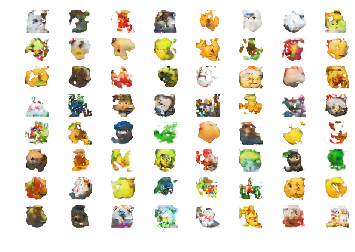

twitter


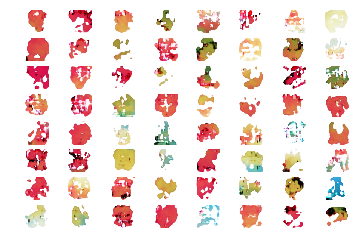

google


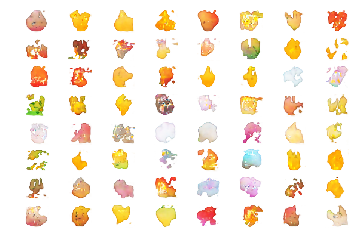

In [0]:
 for i in range(len(styles)):
  print(styles[i])
  IPython.display.display(models[i].sample_images(8,8))

This gives us some really interesting results, and we can see clear differences in the resulting sets produced by our GANs. The Apple emojis show heavy gradients and color changes, while the Google and Twitter sets are much flatter. The Twitter set also skews red and green, while the Google set has more yellows and pastels. Overall this shows how the right architecture for our GAN captures important elements of style.